# Лабораторная работа №2. Системы линейных алгебраических уравнений

Цель работы: решить СЛАУ следующими способами:
- метод Гаусса с выбором главного элемента
- метод LU-разложения (если применим)
- метод Якоби
- метод Зейделя
- метод верхней релаксации
- метод градиентного спуска
- метод минимальных невязок
- стабилизированный метод бисопряженных градиентов

Для итерационных методов получить график убывания невязки в зависимости от итерации

Импортируем библиотеки:

In [1]:
import numpy as np
import sympy as sym
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import os
import sys
from IPython.display import display, Markdown

Выбранная СЛАУ \--- вариант р) из номера II.10.5. (практикум Аристова, Лобанова, Завьялова)
![SOLE](var.jpeg)

Выпишем необходимую матрицу, свободный вектор, а также напишем функцию для дампа матрицы:

In [2]:
n = 49 

def initialMatrix():
    a_i = lambda i: 1
    b_i = lambda i: 5
    c_i = lambda i: 1
    p_i = lambda i: 1 

    matA = np.zeros((n + 1, n + 1))

    for idx in range(0, n):
        matA[idx, idx] = b_i(idx)

    for idx in range(0, n - 1):
        matA[idx + 1, idx] = a_i(idx)

    for idx in range(0, n):
        matA[idx, idx + 1] = c_i(idx)

    for idx in range(0, n + 1):
        matA[n, idx] = p_i(idx)
    
    return matA

def initialFreevec():
    f_i = lambda i: i+1
    
    vecF = np.empty([n + 1])
    for idx in range(0, n + 1):
        vecF[idx] = f_i(idx)

    return vecF


def dumpMatrix(matrix):
    display(pd.DataFrame(matrix))

dumpMatrix(initialMatrix())


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Для дальнейнего анализа нам понадобятся функции нормы вектора и матрицы.

In [3]:
def norm(vec):
    return np.linalg.norm(vec, ord=np.inf)

def mat_norm(matrix):
    return np.linalg.norm(matrix, ord=np.inf)


# Метод Гаусса

Ниже представлена имплементация метода Гаусса с выбором главного элемента (leader).

In [4]:

def swapCols(matrix, first, second):
    matrix[:, [first, second]] = matrix[:, [second, first]]

def swapRows(matrix, first, second):
    matrix[[first, second]] = matrix[[second, first]]

def soleGauss(matrix, free):
    matrix = matrix.copy()
    free = free.copy()
    dim = matrix.shape[0]

    # Positions of variables
    vars = np.arange(dim)

    # Direct pass with choosing max leader
    for cur in range(0, dim - 1):
        # Find max value in submatrix
        submatrix = matrix[cur:, cur:]
        max_y, max_x = np.unravel_index(np.argmax(submatrix), submatrix.shape)
        max_y += cur
        max_x += cur

        # Swap with leader
        swapRows(matrix, cur, max_y)
        swapCols(matrix, cur, max_x)
        vars[[cur, max_x]] = vars[[max_x, cur]]
        free[[cur, max_y]] = free[[max_y, cur]]

        # Subtract current row from remaining rows
        for idx in range(cur + 1, dim):
            factor = matrix[idx, cur] / matrix[cur, cur]
            matrix[idx] -= factor * matrix[cur]
            free[idx]   -= factor * free[cur]

    roots = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = free[cur]
        for idx in range(cur + 1, dim):
            tmp -= matrix[cur, idx] * roots[idx]

        roots[cur] = tmp / matrix[cur][cur]

    # Restore variable order
    tmp = np.zeros(dim)
    for cur in range(0, dim):
        tmp[vars[cur]] = roots[cur]

    roots = tmp
    return roots

Убедимся, что метод Гаусса работает верно. Для этого посчитаем два числа: норму разности нашего решения по методу Гаусса и решения, почитанному с помощью библиотеки linalg, а также разность (A, u) и f. 

In [5]:
A = initialMatrix()
f = initialFreevec()

u = soleGauss(A, f)
ref_u = np.linalg.solve(A, f)

print("Норма разности решений: ", norm(u - ref_u))
print("(A,u) - f: ", norm(np.matmul(A, u) - f))

Норма разности решений:  2.842170943040401e-14
(A,u) - f:  2.842170943040401e-14


Учитывая существование машинной погрешности приходим к выводу, что метод Гаусса реализован верно.

# LU-разложение

LU-разложение -- это представление исходной матрицы A в виде произведение двух матриц: A = L*U, где L -- нижняя треугольная матрица, а U -- верхняя треугольная матрица.

Напишем функцию для получения этих матриц:

In [6]:
def getLU(matrix):
    dim = matrix.shape[0]
    U = matrix.copy()
    L = np.identity(dim)

    for leader in range(0, dim):
        for idx in range(leader + 1, dim):
            L[idx, leader] = U[idx, leader] / U[leader, leader]
            U[idx] -= L[idx, leader] * U[leader]

    return L, U

А также функцию для решения СЛАУ с помощью LU-разложения:

In [7]:

def soleLU(matrix, free):
    dim = matrix.shape[0]

    L, U = getLU(matrix)

    # Ly = free
    y = np.zeros(dim)
    for cur in range(0, dim):
        tmp = free[cur]
        for idx in range(0, cur):
            tmp -= L[cur, idx] * y[idx]
        y[cur] = tmp / L[cur, cur]
    
    # Ux = y
    x = np.zeros(dim)
    for cur in reversed(range(0, dim)):
        tmp = y[cur]
        for idx in range(cur + 1, dim):
            tmp -= U[cur, idx] * x[idx]
        x[cur] = tmp / U[cur][cur]

    return x

Проверим правильность LU-разложения и решения СЛАУ:

In [8]:
A = initialMatrix()
f = initialFreevec()

L, U = getLU(A)
L_ref, U_ref = sp.linalg.lu(A, permute_l=True)
print("LU разложение:")
print("norm(L-L_ref): ", mat_norm(L - L_ref))
print("norm(U-U_ref): ", mat_norm(U - U_ref))

ref_u = np.linalg.solve(A, f)
roots = soleLU(A, f)

print("Решение:")
print("Норма разности решений: ", norm(u - ref_u))
print("(A,u) - f: ", norm(np.matmul(A, u) - f))

LU разложение:
norm(L-L_ref):  8.326672684688674e-17
norm(U-U_ref):  1.1102230246251565e-16
Решение:
Норма разности решений:  2.842170943040401e-14
(A,u) - f:  2.842170943040401e-14


# Итерационные методы

Далее рассмотрим метод Зейделя, Якоби и метод верхней релаксации (successive over-relaxation -- SOR).

Для итерационных методов построим график завимости невязки от итерации. Для этого напишем функцию решения уравнения с имеющимися B и F, где значения невязки будем класть в массив diff. 

Для того, чтобы выразить B и F, также напишем функцию для нахождения LDU разложения.

In [9]:
def soleFpi(n_iter, B, F, matrix, free):
    dim = matrix.shape[0]
    u = np.zeros(dim)

    diff = []
    for it in range(0, n_iter):
        u = np.matmul(B, u) + F
        diff.append(norm(np.matmul(matrix, u) - free))
    
    return u, diff

def getLDU(matrix):
    dim = matrix.shape[0]

    inds = np.tril_indices(dim, k=-1) 
    L = np.zeros(matrix.shape)
    L[inds] = matrix[inds]

    inds = np.triu_indices(dim, k=1)
    U = np.zeros(matrix.shape)
    U[inds] = matrix[inds]

    inds = np.diag_indices(dim)
    D = np.zeros(matrix.shape)
    D[inds] = matrix[inds]

    return L, D, U

Реализация методов:

In [10]:
def soleZeydel(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(L + D), U)
    F = np.matmul(np.linalg.inv(L + D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleJacobi(n_iter, matrix, free):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D), L + U)
    F = np.matmul(np.linalg.inv(D), free)

    return soleFpi(n_iter, B, F, matrix, free)

def soleSOR(n_iter, matrix, free, tau):
    L, D, U = getLDU(matrix)
    B = - np.matmul(np.linalg.inv(D + tau * L), (tau - 1) * D + tau * U)
    F = tau * np.matmul(np.linalg.inv(D + tau * L), free)

    return soleFpi(n_iter, B, F, matrix, free)



Сравнение (Зейдель):
Норма разности решений:  2.842170943040401e-14
(A,u) - f:  2.842170943040401e-14
Сравнение (Якоби):
Норма разности решений:  7.105427357601002e-15
(A,u) - f:  2.842170943040401e-14
Сравнение (МВР):
Норма разности решений:  5.684341886080802e-14
(A,u) - f:  2.842170943040401e-14


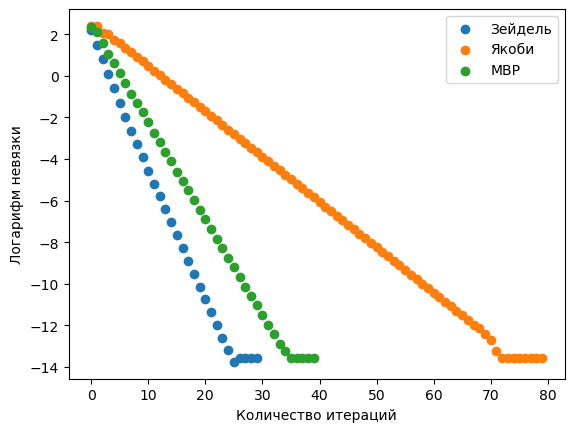

In [11]:
def test(method, n_iter, name):
    A = initialMatrix()
    f = initialFreevec()

    u, diff = method(n_iter, A, f)
    ref_u = np.linalg.solve(A, f)

    print(f"Сравнение ({name}):")
    print("Норма разности решений: ", norm(u - ref_u))
    print("(A,u) - f: ", norm(np.matmul(A, u) - f))

    plt.scatter(range(0, len(diff)), np.log10(diff), label=name)

test(soleZeydel, 30, "Зейдель")
test(soleJacobi, 80, "Якоби")
test(lambda n_iter, matrix, free: soleSOR(n_iter, matrix, free, 1.2), 40, "МВР")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()
plt.show()

Видим, что лучше всего себя показал метод Зейделя. Также отметим, что если принять коэффициент в МВР единицей, то получим ожидаемый результат: МВР эквивалентен методу Зейделя.

# Вариационные методы

Сразу отметим, что для последующих методов надо работать с симметричной матрицей.

In [ ]:
n = 2

def initialMatrix():
    a_i = lambda i: 1
    b_i = lambda i: 5
    c_i = lambda i: 1
    p_i = lambda i: 1 

    matA = np.zeros((n + 1, n + 1))

    matA [0,]

    for idx in range(0, n):
        matA[idx, idx] = b_i(idx)

    for idx in range(0, n - 1):
        matA[idx + 1, idx] = a_i(idx)

    for idx in range(0, n):
        matA[idx, idx + 1] = c_i(idx)

    for idx in range(0, n + 1):
        matA[n, idx] = p_i(idx)
    
    return matA

In [12]:
def soleFpi(n_iter, tau, matrix, free):
    dim = matrix.shape[0]
    u = np.full(dim, 2)

    diff = []
    
    for it in range(0, n_iter):
        res =  free - np.matmul(matrix, u)
        u = u + tau(matrix, res) * res
        
        diff.append(norm(res))
    
    return u, diff

In [13]:
def grad_desc(matrix, res):
    A_r = np.matmul(matrix, res)
    return np.matmul(res, res) / np.matmul(A_r, res)
    return

def min_res(matrix, res):
    A_r = np.matmul(matrix, res)
    return np.matmul(A_r, res) / np.matmul(A_r, A_r)

Сравнение (Градиентный спуск):
Норма разности решений:  1.6200374375330284e-12
(A,u) - f:  5.684341886080801e-13
Сравнение (Минимальная невязка):
Норма разности решений:  1.7337242752546445e-12
(A,u) - f:  6.821210263296962e-13


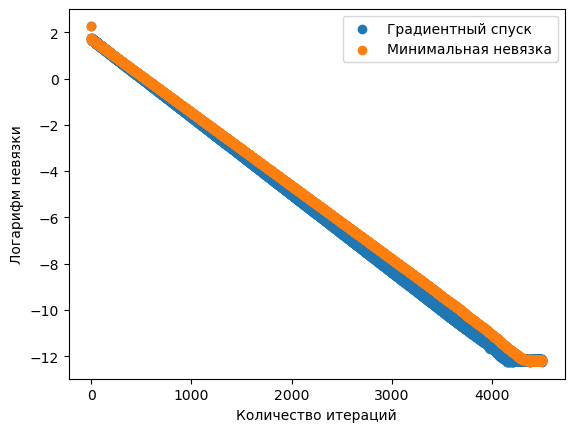

In [14]:
def test(method, n_iter, name):
    A = initialMatrix()
    A_transpose = np.transpose(A)
    # Symmetrize
    A = np.matmul(A_transpose, A)
    f = np.matmul(A_transpose, initialFreevec())

    values, vectors = np.linalg.eig(A)

    u, diff = soleFpi(n_iter, method, A, f)
    ref_u = np.linalg.solve(A, f)

    print(f"Сравнение ({name}):")
    print("Норма разности решений: ", norm(u - ref_u))
    print("(A,u) - f: ", norm(np.matmul(A, u) - f))

    plt.scatter(range(0, len(diff)), np.log10(diff), label=name)

test(grad_desc, 4500, "Градиентный спуск")
test(min_res, 4500, "Минимальная невязка")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()
plt.show()

Видим, что количество итераций сильно возросло. При этом если проанализировать какие- то другие случайные матрицы, то можно увидеть, что кол-во итераций не превышает ожидаемого: следовательно, дело в самой матрице. Здесь может быть несколько причин: либо матрица имеет очень маленькие собственный значения (т.е. является почти вырожденной), либо еще как-то довольно специфичная причина. Проверить первую гипотезу легко:

In [15]:
eigval, eigvec = np.linalg.eig(A)
eigval

array([0.79793197, 3.00397825, 3.0157706 , 3.03570655, 3.06283368,
       3.09864451, 3.14044703, 3.1917674 , 3.24738664, 3.3135675 ,
       3.38196601, 3.46208508, 3.54206275, 3.63494485, 3.72515202,
       3.82939648, 3.92834641, 4.04235868, 4.14844142, 4.27046687,
       4.38196601, 4.51012456, 4.62523737, 4.75755805, 4.87441896,
       5.00887424, 5.12558104, 5.26012047, 5.37476263, 5.50734577,
       5.61803399, 5.74666227, 7.02359238, 6.9842294 , 6.97523991,
       6.93716632, 6.91370837, 6.85955297, 6.82142343, 6.75261336,
       6.70039037, 6.61803399, 6.55262501, 5.85155858, 6.45793725,
       6.38048615, 6.27484798, 6.186695  , 5.97430589, 6.07165359])

Видим, что собственные значения *вроде* в порядке. 

В целом, ситуация очень странная: практическим путем можно заметить, что матрица тут же становится "хорошей", как только мы уделаем элемент [49, 49] больше, при этм его уменьшение, наоборот, ведет в отрицательному результату. Как-то хорошо обосновать это у меня не получилось, разве что число обусловленности матрицы  при увеличении элемента становится выше (хоть оно и не особо большое).

# Приложение

Ниже приведена матрица для проверки гипотезы выше. Можно поиграться и посмотреть, что происходит. 

In [16]:
def initialMatrix():
    a_i = lambda i: 1
    b_i = lambda i: 5
    c_i = lambda i: 1
    p_i = lambda i: 1 

    matA = np.zeros((n + 1, n + 1))

    for idx in range(0, n +1):
        matA[idx, idx] = b_i(idx)

    for idx in range(0, n ):
        matA[idx + 1, idx] = a_i(idx)

    for idx in range(0, n):
        matA[idx, idx + 1] = c_i(idx)

    for idx in range(0, n ):
        matA[n, idx] = p_i(idx)
    
    matA[49, 49] = 0.5

    return matA
    
eigval, eigvec = np.linalg.eig(initialMatrix())


dumpMatrix(initialMatrix())
eigval

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([0.31681348, 3.00397295, 3.0157706 , 3.03566004, 3.06283368,
       3.09852176, 3.14044703, 3.19154394, 3.24738664, 3.31323111,
       3.38196601, 3.4616349 , 3.54206275, 3.63438879, 3.72515202,
       3.82874799, 3.92834641, 4.04163382, 4.14844142, 4.26968201,
       4.38196601, 4.5092949 , 4.62523737, 4.75669685, 4.87441896,
       5.0079925 , 5.12558104, 5.25922697, 5.37476263, 5.50644733,
       5.61803399, 5.74576408, 7.02032757, 6.9842294 , 6.97470456,
       6.93716632, 6.91296507, 6.85955297, 6.82061167, 6.75261336,
       6.69954645, 6.61803399, 6.55176179, 6.45793725, 6.37960942,
       5.85155858, 6.27484798, 6.18580821, 5.97341184, 6.07165359])

Сравнение (Градиентный спуск):
Норма разности решений:  2.5124791136477143e-11
(A,u) - f:  7.958078640513122e-13
Сравнение (Минимальная невязка):
Норма разности решений:  4.5986325858393684e-11
(A,u) - f:  1.8189894035458565e-12


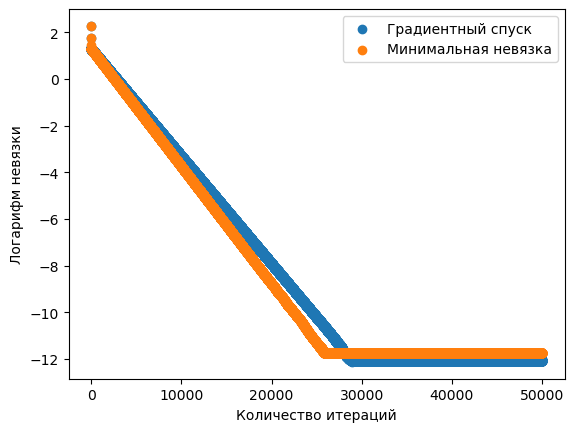

In [17]:
test(grad_desc, 50000, "Градиентный спуск")
test(min_res, 50000, "Минимальная невязка")

plt.xlabel("Количество итераций")
plt.ylabel("Логарифм невязки")
plt.legend()
plt.show()